In [1]:
# Import packages

import pandas as pd 
import numpy as np 
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import statsmodels.api as sm
from scipy import stats

from joblib import dump, load

pd.set_option('display.max_columns', None)

C:\Users\imacd_0odruq3\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\imacd_0odruq3\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
nfl = pd.read_csv('../../data/nfl_game_by_game_raw_stats.csv')

In [3]:
nfl.head()

,season,week,team,opponent,score,opponent_score,qb,total_pass_attempts,total_passing_yards,completions,passing_epa,pass_tds,air_yards,yards_after_catch,air_epa,yac_epa,avg_cpoe,total_rushes,total_rush_yards,rushing_epa,rush_tds,qb_epa,qb_rush_yards,qb_rushing_epa,qb_rush_tds,total_qb_rush_attempts,sacks_taken_qb,qb_hits_taken_qb,fumbles_qb,lost_fumbles_qb,interceptions_thrown_qb,sacks_allowed_team,qb_hits_allowed_team,fumbles_team,lost_fumbles_team,interceptions_thrown_team,total_rushes_allowed,total_rush_yards_allowed,rushing_epa_allowed,rush_tds_allowed,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,interceptions,fumbles_recovered,special_teams_epa,total_epa,total_opposing_epa
0,2014,1,ARI,LAC,18,17,C. Palmer,38,304.0,24.0,6.098425,2.0,196.0,108.0,10.800692,13.884696,3.160065,26,110.0,-7.697317,0.0,7.779734,30.0,1.681309,0.0,3.0,2.0,4.0,1.0,1.0,0.0,2.0,4.0,2.0,2.0,0.0,24,52.0,-8.805075,1.0,36,238.0,21.0,0.799435,1.0,148.0,90.0,8.328671,10.101167,-6.609174,-1.749010,10.0,-2.548446,0.0,0.0,4.0,0.0,1.0,0.0,-4.751772,1.654976,-1.654976
1,2014,1,ATL,NO,37,34,M. Ryan,42,448.0,31.0,17.253965,3.0,253.0,195.0,8.815695,16.383532,6.128030,25,123.0,2.559394,1.0,24.116820,15.0,0.272050,0.0,3.0,1.0,4.0,1.0,1.0,0.0,1.0,4.0,1.0,1.0,0.0,28,139.0,4.264254,3.0,42,333.0,29.0,9.202585,1.0,141.0,192.0,1.711281,22.435846,-0.291977,13.906331,2.0,-0.387024,0.0,0.0,0.0,1.0,1.0,1.0,-1.162613,5.183908,-5.183908
2,2014,1,BAL,CIN,16,23,J. Flacco,62,345.0,35.0,-4.871386,1.0,221.0,124.0,10.962930,14.313325,-11.889451,21,94.0,-0.093163,1.0,-3.078329,7.0,1.793058,0.0,3.0,3.0,6.0,0.0,0.0,1.0,3.0,6.0,1.0,1.0,1.0,24,81.0,-4.888501,0.0,39,303.0,25.0,11.252418,1.0,129.0,172.0,-3.613447,26.073280,-2.044220,7.354762,5.0,-3.897657,0.0,0.0,1.0,0.0,0.0,0.0,-2.107624,-13.436091,13.436091
3,2014,1,BUF,CHI,23,20,E. Manuel,22,173.0,16.0,0.368607,1.0,93.0,80.0,1.909633,9.530254,11.150598,31,197.0,4.315138,1.0,0.591515,23.0,0.222908,1.0,4.0,1.0,3.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,1.0,18,86.0,-0.055888,0.0,49,349.0,34.0,-6.755498,2.0,159.0,190.0,3.427141,16.035978,2.864331,0.058386,0.0,0.000000,0.0,2.0,4.0,1.0,2.0,1.0,3.721131,15.216262,-15.216262
4,2014,1,CAR,TB,20,14,D. Anderson,33,230.0,24.0,8.423189,2.0,160.0,70.0,6.298791,10.724494,9.822589,33,113.0,-6.247634,0.0,10.352312,10.0,1.929123,0.0,3.0,1.0,3.0,1.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,17,102.0,1.025410,0.0,35,183.0,22.0,-10.437735,2.0,138.0,45.0,6.082325,4.351872,0.519191,-3.645375,27.0,2.277812,0.0,3.0,9.0,2.0,2.0,1.0,-3.457676,8.130204,-8.130204


In [4]:
# Previous iteration tried to predict passing value using a modeling approach. The issue I found with this is that it 
# is difficult to create a label corresponding to a "good" quarterback game. In this approach, the focus will be 
# transforming the necessary features using scaling/normalization/etc. This approach should result in minimal changes
# to the actual value of the feature, just changing the representation.

In [5]:
# Get only passing related stats for qbs that threw more than 10 passes in the game

st = nfl.copy()
st = st[['season', 'week', 'team', 'opponent', 'score', 'opponent_score', 'special_teams_epa']]
st = st.drop_duplicates()
st

,season,week,team,opponent,score,opponent_score,special_teams_epa
0,2014,1,ARI,LAC,18,17,-4.751772
1,2014,1,ATL,NO,37,34,-1.162613
2,2014,1,BAL,CIN,16,23,-2.107624
3,2014,1,BUF,CHI,23,20,3.721131
4,2014,1,CAR,TB,20,14,-3.457676
...,...,...,...,...,...,...,...
5864,2022,21,KC,CIN,23,20,-1.364441
5865,2022,21,PHI,SF,31,7,-2.847893
5866,2022,21,SF,PHI,7,31,2.847893
5869,2022,22,KC,PHI,38,35,-1.324550


In [6]:
st.special_teams_epa

0      -4.751772
1      -1.162613
2      -2.107624
3       3.721131
4      -3.457676
          ...   
5864   -1.364441
5865   -2.847893
5866    2.847893
5869   -1.324550
5870    1.324550
Name: special_teams_epa, Length: 4880, dtype: float64

In [7]:
# Look at the distribution of st epa. Should it be left as is? Scaled?

np.mean(st.special_teams_epa)

-6.006124559447568e-18

In [8]:
np.max(st.special_teams_epa)

23.355742

In [9]:
np.min(st.special_teams_epa)

-23.355742

In [10]:
best_st_performances = st.sort_values(by='special_teams_epa', ascending=False)
best_st_performances.head(20)

,season,week,team,opponent,score,opponent_score,special_teams_epa
4259,2020,13,NE,LAC,45,0,23.355742
2670,2018,5,DET,GB,31,23,23.264954
2532,2018,1,KC,LAC,38,28,20.586332
2078,2017,6,LA,JAX,27,17,18.770428
442,2014,13,MIN,CAR,31,13,16.433306
1542,2016,9,KC,JAX,19,14,15.996090
1346,2016,3,NE,HOU,27,0,15.986924
2064,2017,6,BAL,CHI,24,27,15.875930
80,2014,3,CIN,TEN,33,7,15.521590
4795,2021,9,KC,GB,13,7,15.466981


In [11]:
worst_st_performances = st.sort_values(by='special_teams_epa', ascending=True)
worst_st_performances.head(20)

,season,week,team,opponent,score,opponent_score,special_teams_epa
4255,2020,13,LAC,NE,0,45,-23.355742
2671,2018,5,GB,DET,23,31,-23.264954
2534,2018,1,LAC,KC,28,38,-20.586332
2076,2017,6,JAX,LA,17,27,-18.770428
423,2014,13,CAR,MIN,13,31,-16.433306
1541,2016,9,JAX,KC,14,19,-15.996090
1337,2016,3,HOU,NE,0,27,-15.986924
2066,2017,6,CHI,BAL,27,24,-15.875930
112,2014,3,TEN,CIN,7,33,-15.521590
4789,2021,9,GB,KC,7,13,-15.466981


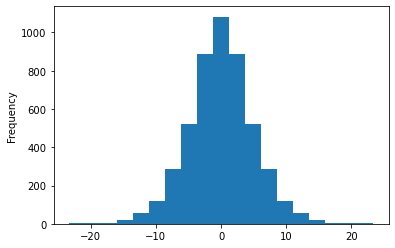

In [12]:
st.special_teams_epa.plot.hist(bins=19)

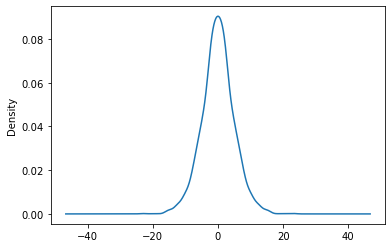

In [13]:
st.special_teams_epa.plot.kde()

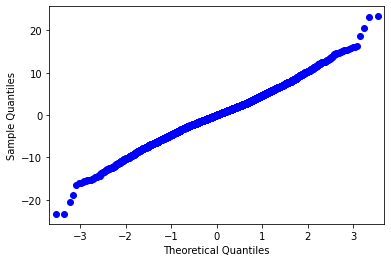

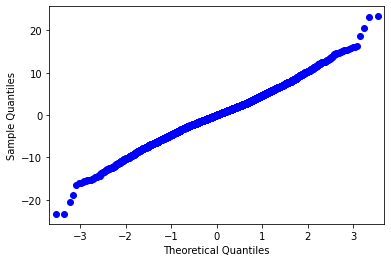

In [14]:
sm.qqplot(st.special_teams_epa)

In [15]:
# Removing some outliers

st_no_outliers = st.copy()
st_no_outliers = st_no_outliers[np.abs(st_no_outliers.special_teams_epa) <= 15]
st_no_outliers

,season,week,team,opponent,score,opponent_score,special_teams_epa
0,2014,1,ARI,LAC,18,17,-4.751772
1,2014,1,ATL,NO,37,34,-1.162613
2,2014,1,BAL,CIN,16,23,-2.107624
3,2014,1,BUF,CHI,23,20,3.721131
4,2014,1,CAR,TB,20,14,-3.457676
...,...,...,...,...,...,...,...
5864,2022,21,KC,CIN,23,20,-1.364441
5865,2022,21,PHI,SF,31,7,-2.847893
5866,2022,21,SF,PHI,7,31,2.847893
5869,2022,22,KC,PHI,38,35,-1.324550


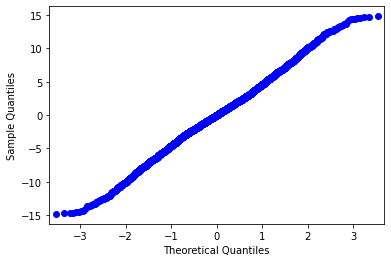

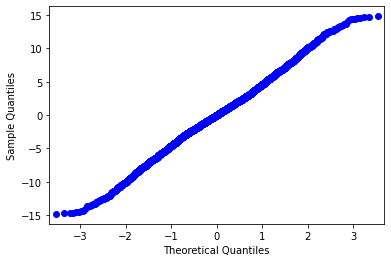

In [16]:
sm.qqplot(st_no_outliers.special_teams_epa)

In [17]:
# Looks normal, creating a variable to normalize special_teams_epa

st_epa_mean = np.mean(st_no_outliers.special_teams_epa)
st_epa_std = np.std(st_no_outliers.special_teams_epa)
st['special_teams_epa_standardized'] = st.apply(lambda x: (x.special_teams_epa - st_epa_mean)/st_epa_std, axis=1)

st.head()

,season,week,team,opponent,score,opponent_score,special_teams_epa,special_teams_epa_standardized
0,2014,1,ARI,LAC,18,17,-4.751772,-0.996743
1,2014,1,ATL,NO,37,34,-1.162613,-0.243872
2,2014,1,BAL,CIN,16,23,-2.107624,-0.442100
3,2014,1,BUF,CHI,23,20,3.721131,0.780553
4,2014,1,CAR,TB,20,14,-3.457676,-0.725290


In [18]:
# Still not sure whats best. Per attempt gives higher praise for good games w few passes and penalized more heavily for
# bad games with fewer passes. Going to start with total, but may need to change this later.

st_to_save = st.copy()
st_to_save['special_teams_value'] = st_to_save.special_teams_epa_standardized
st_to_save.head()

,season,week,team,opponent,score,opponent_score,special_teams_epa,special_teams_epa_standardized,special_teams_value
0,2014,1,ARI,LAC,18,17,-4.751772,-0.996743,-0.996743
1,2014,1,ATL,NO,37,34,-1.162613,-0.243872,-0.243872
2,2014,1,BAL,CIN,16,23,-2.107624,-0.442100,-0.442100
3,2014,1,BUF,CHI,23,20,3.721131,0.780553,0.780553
4,2014,1,CAR,TB,20,14,-3.457676,-0.725290,-0.725290


In [19]:
st_to_save.to_csv('special_teams_value_model_v2_data/special_teams_with_value.csv')

In [20]:
# Look at best/worst qbs by st epa standardized

sts = st.groupby(by=['team']).agg({'special_teams_epa_standardized': 'mean', 'week':'count'}).reset_index()
sts

,team,special_teams_epa_standardized,week
0,ARI,-0.158392,150
1,ATL,0.122127,151
2,BAL,0.469247,153
3,BUF,0.143974,154
4,CAR,-0.074966,152
5,CHI,-0.082597,148
6,CIN,0.048606,154
7,CLE,-0.173482,148
8,DAL,0.094472,154
9,DEN,-0.240689,150


In [21]:
sts.sort_values(by='special_teams_epa_standardized', ascending = True).head(20)

,team,special_teams_epa_standardized,week
17,LAC,-0.380290,149
29,TB,-0.280046,153
9,DEN,-0.240689,150
11,GB,-0.206212,158
7,CLE,-0.173482,148
0,ARI,-0.158392,150
26,PIT,-0.140043,155
31,WAS,-0.123134,148
20,MIN,-0.122017,152
28,SF,-0.106534,155


In [22]:
sts.sort_values(by='special_teams_epa_standardized', ascending = False).head(20)

,team,special_teams_epa_standardized,week
2,BAL,0.469247,153
21,NE,0.331377,162
13,IND,0.208687,152
27,SEA,0.194245,158
15,KC,0.188325,164
10,DET,0.174518,148
3,BUF,0.143974,154
18,LV,0.129081,148
25,PHI,0.122520,156
1,ATL,0.122127,151


In [23]:
sts2 = st.groupby(by=['team', 'season']).agg({'special_teams_epa_standardized': 'mean', 'week':'count'}).reset_index()
sts2

,team,season,special_teams_epa_standardized,week
0,ARI,2014,-0.164285,17
1,ARI,2015,-0.440671,18
2,ARI,2016,-0.494621,16
3,ARI,2017,-0.282919,16
4,ARI,2018,0.212380,16
...,...,...,...,...
283,WAS,2018,0.304714,16
284,WAS,2019,0.160690,16
285,WAS,2020,-0.430221,17
286,WAS,2021,-0.048688,17


In [24]:
sts2.sort_values(by='special_teams_epa_standardized', ascending = False).head(20)

,team,season,special_teams_epa_standardized,week
225,PHI,2014,0.805012,16
20,BAL,2016,0.712042,16
24,BAL,2020,0.710440,18
189,NE,2014,0.679927,19
195,NE,2020,0.609159,16
220,NYJ,2018,0.602735,16
137,KC,2016,0.593075,17
249,SEA,2020,0.589922,17
192,NE,2017,0.581259,19
119,IND,2016,0.575243,16


In [25]:
sts2.sort_values(by='special_teams_epa_standardized', ascending = True).head(20)

,team,season,special_teams_epa_standardized,week
159,LAC,2020,-0.896198,16
186,MIN,2020,-0.895859,16
84,DEN,2017,-0.825057,16
258,SF,2020,-0.712360,16
150,LA,2020,-0.689811,18
210,NYG,2017,-0.645754,16
218,NYJ,2016,-0.626284,16
90,DET,2014,-0.604287,17
156,LAC,2017,-0.600226,16
89,DEN,2022,-0.599192,17
